In [ ]:
import os
import numpy as np
import cv2
import zipfile
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from google.colab import files
from IPython.display import display, Image as IPImage

In [ ]:
#Uploadind Zip file
zip_path = '/content/Dataset.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Thedataset directory
DATASET_DIR = '/content/TB_Chest_Radiography_Database'

file_paths = []
labels = []

for label_dir in ['Normal', 'Tuberculosis']:
    folder_path = os.path.join(DATASET_DIR, label_dir)
    label = 0 if label_dir == 'Normal' else 1
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

# Shuffle and split
combined = list(zip(file_paths, labels))
random.shuffle(combined)
file_paths, labels = zip(*combined)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42)

In [ ]:
class GrayscaleImageDataGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size=32, img_size=(224, 224), shuffle=True):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_filenames, self.labels))
            random.shuffle(combined)
            self.image_filenames, self.labels = zip(*combined)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for file in batch_x:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = np.stack((img,) * 3, axis=-1)
            img = img / 255.0
            images.append(img)

        return np.array(images), np.array(batch_y)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

train_generator = GrayscaleImageDataGenerator(train_paths, train_labels, BATCH_SIZE)
val_generator = GrayscaleImageDataGenerator(val_paths, val_labels, BATCH_SIZE, shuffle=False)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 439ms/step - accuracy: 0.8008 - loss: 2.4422 - val_accuracy: 0.8964 - val_loss: 1.2809 - learning_rate: 1.0000e-04
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 416ms/step - accuracy: 0.8542 - loss: 0.9498 - val_accuracy: 0.8750 - val_loss: 0.7601 - learning_rate: 1.0000e-04
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 413ms/step - accuracy: 0.8742 - loss: 0.6262 - val_accuracy: 0.9048 - val_loss: 0.5398 - learning_rate: 1.0000e-04
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 419ms/step - accuracy: 0.9043 - loss: 0.4755 - val_accuracy: 0.9190 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 414ms/step - accuracy: 0.8956 - loss: 0.4229 - val_accuracy: 0.9095 - val_loss: 0.4100 - learning_rate: 1.0000e-04
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 416ms/step - accuracy: 0.9218 - loss: 0.3524 - val_accuracy: 0.9440 - val_loss: 0.3939 - learning_rate: 1.0000e-04
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 43

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {accuracy*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.9871 - loss: 0.1728

✅ Validation Accuracy: 98.21%



📤 Upload a chest X-ray image (JPG/PNG):


Saving Tuberculosis-2.png to Tuberculosis-2 (1).png


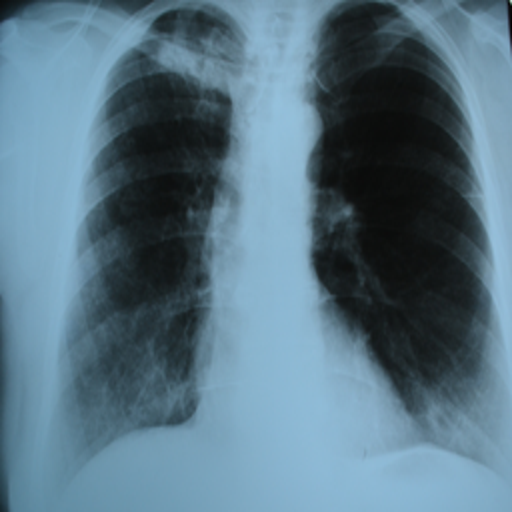

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🧠 Model Prediction: ⚠️ Tuberculosis affected
🔍 Confidence: 98.41%


In [ ]:
print("\n📤 Upload a chest X-ray image (JPG/PNG):")
uploaded = files.upload()

for filename in uploaded:
    img_path = filename
    display(IPImage(filename=img_path))

    # Step 3 — Standardize uploaded image (grayscale to 3-channel)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack((img,) * 3, axis=-1)
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    # Prediction
    prediction = model.predict(img_array)[0][0]
    result = "✅ Normal (No Tuberculosis)" if prediction < 0.5 else "⚠️ Tuberculosis affected"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"\n🧠 Model Prediction: {result}")
    print(f"🔍 Confidence: {confidence*100:.2f}%")


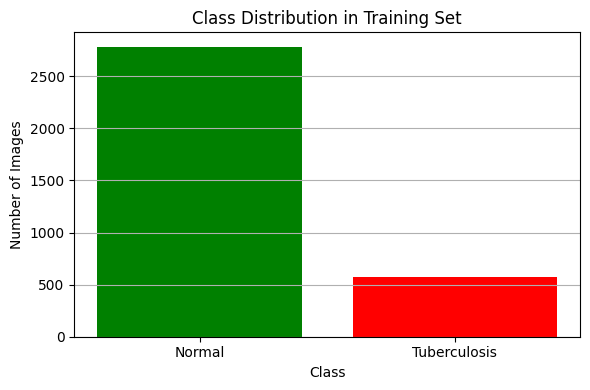

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count class distribution in training set
class_counts = Counter(train_labels)
class_names = ['Normal', 'Tuberculosis']
counts = [class_counts[0], class_counts[1]]

# Plotting
plt.figure(figsize=(6,4))
plt.bar(class_names, counts, color=['green', 'red'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


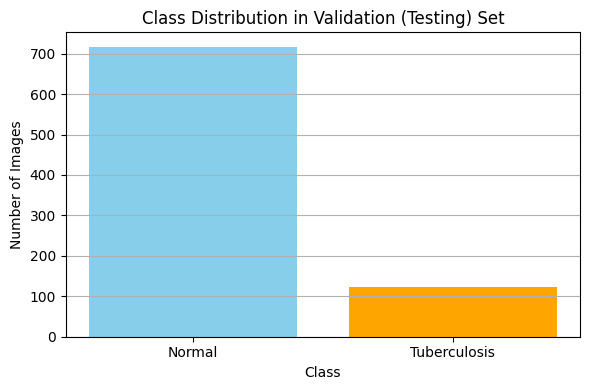

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count class distribution in validation/testing set
val_class_counts = Counter(val_labels)
class_names = ['Normal', 'Tuberculosis']
counts = [val_class_counts[0], val_class_counts[1]]

# Plotting
plt.figure(figsize=(6,4))
plt.bar(class_names, counts, color=['skyblue', 'orange'])
plt.title('Class Distribution in Validation (Testing) Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


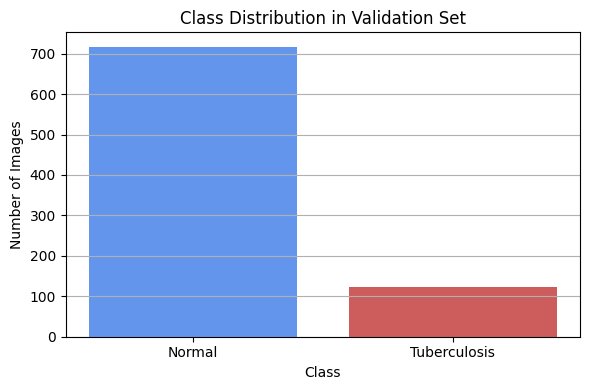

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count class distribution in the validation set
val_counts = Counter(val_labels)
classes = ['Normal', 'Tuberculosis']
values = [val_counts[0], val_counts[1]]

# Plotting
plt.figure(figsize=(6,4))
plt.bar(classes, values, color=['cornflowerblue', 'indianred'])
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


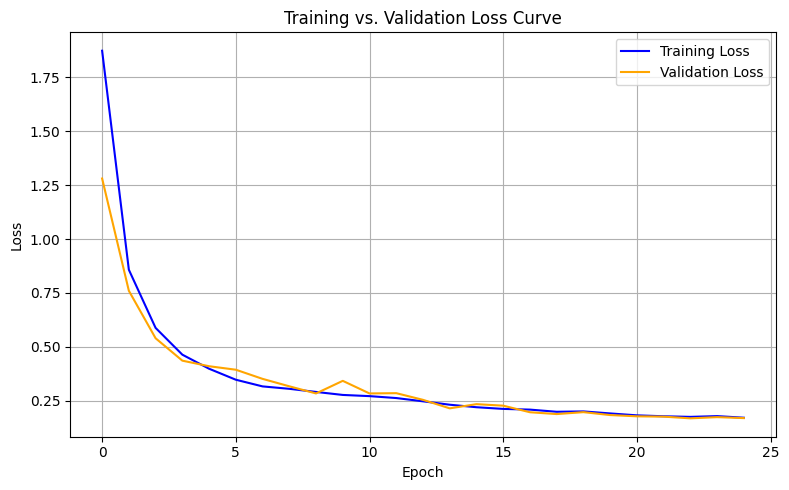

In [ ]:
# Plot loss curve from training history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


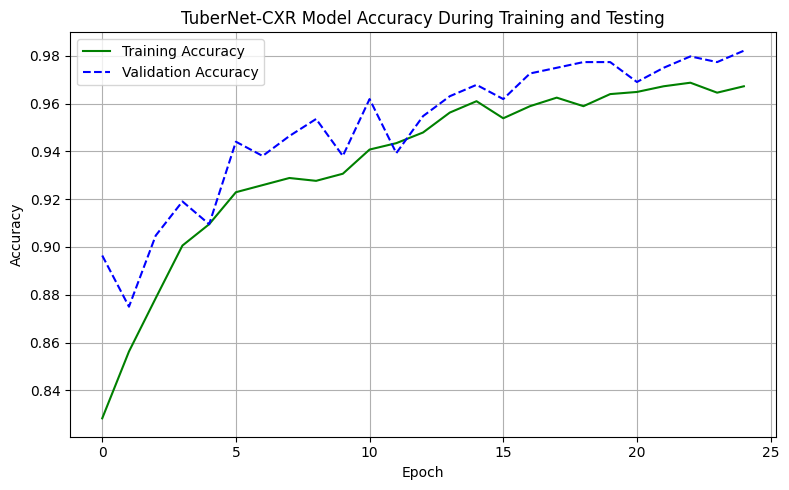

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')

plt.title('TuberNet-CXR Model Accuracy During Training and Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Load base model (pretrained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1
)

/tmp/ipython-input-23-700166950.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_533']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 726ms/step - accuracy: 0.8066 - loss: 0.4488 - val_accuracy: 0.9774 - val_loss: 0.0906
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 397ms/step - accuracy: 0.9640 - loss: 0.1230 - val_accuracy: 0.9881 - val_loss: 0.0483
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 406ms/step - accuracy: 0.9837 - loss: 0.0684 - val_accuracy: 0.9893 - val_loss: 0.0345
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 405ms/step - accuracy: 0.9823 - loss: 0.0633 - val_accuracy: 0.9905 - val_loss: 0.0281
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 408ms/step - accuracy: 0.9869 - loss: 0.0475 - val_accuracy: 0.9929 - val_loss: 0.0251
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.9901 - loss: 0.0342 - val_accuracy: 0.9917 - val_loss: 0.0235
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.9932 - loss: 0.0280 - val_accuracy: 0.9964 - val_loss: 0.0187
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.9942 - loss: 0.0244 - val

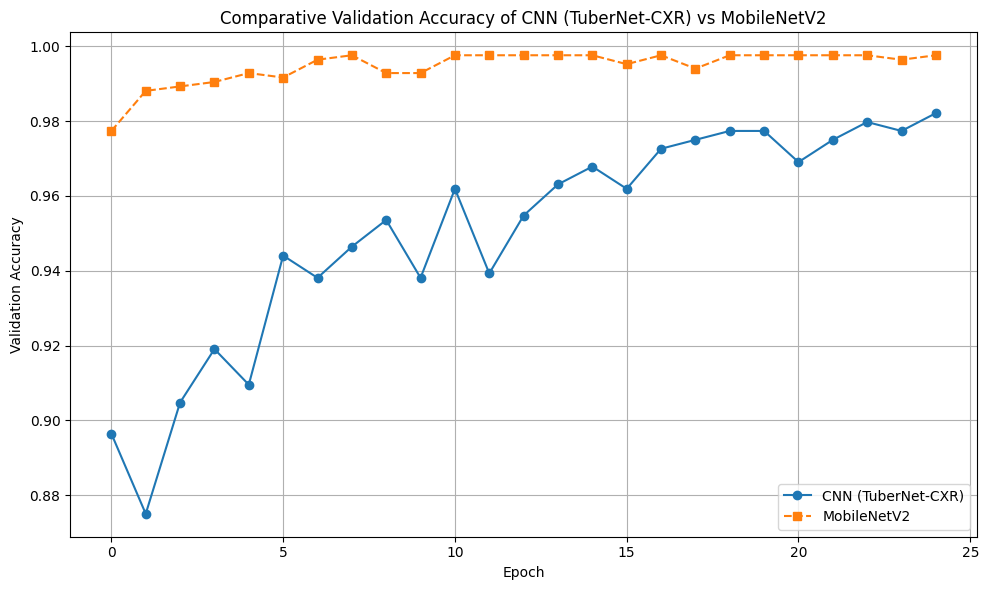

In [ ]:
import matplotlib.pyplot as plt

history_cnn = history

# Plot comparative validation accuracy
plt.figure(figsize=(10,6))

plt.plot(history_cnn.history['val_accuracy'], label='CNN (TuberNet-CXR)', linestyle='-', marker='o')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2', linestyle='--', marker='s')

plt.title('Comparative Validation Accuracy of CNN (TuberNet-CXR) vs MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels
y_true = val_labels

# Predict probabilities
y_pred_probs = model.predict(val_generator, verbose=1)

# Convert probabilities to class labels (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step


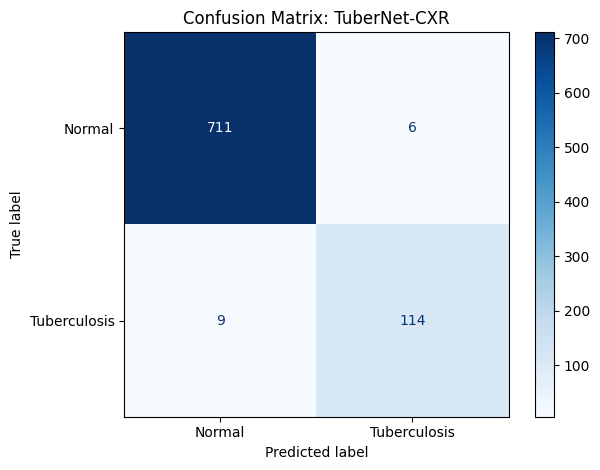

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tuberculosis'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: TuberNet-CXR")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("📊 Classification Report for TuberNet-CXR:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))


📊 Classification Report for TuberNet-CXR:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       717
Tuberculosis       0.95      0.93      0.94       123

    accuracy                           0.98       840
   macro avg       0.97      0.96      0.96       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels
y_true = np.array(val_labels)

# Predict probabilities (not class labels!)
y_scores = model.predict(val_generator, verbose=1).flatten()


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step


In [ ]:
# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)
print(f"🔵 AUC Score for TuberNet-CXR: {roc_auc:.4f}")


🔵 AUC Score for TuberNet-CXR: 0.9919


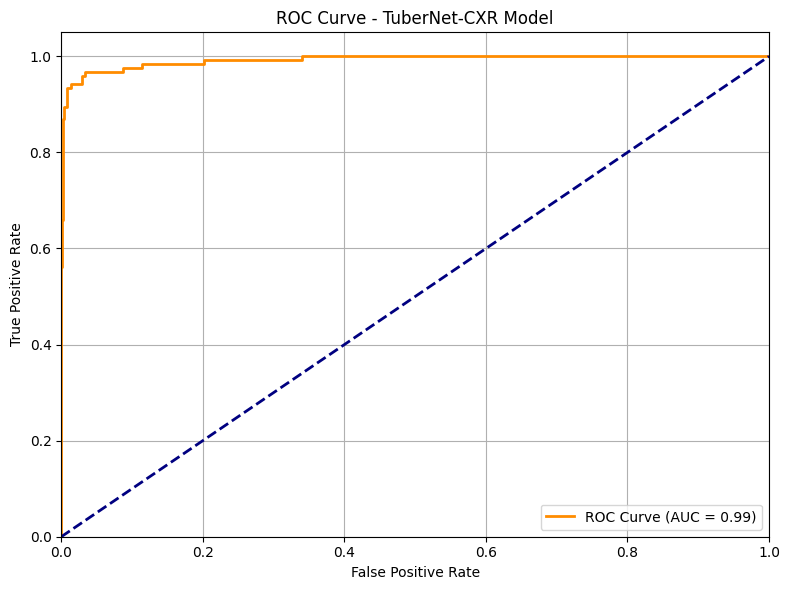

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TuberNet-CXR Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


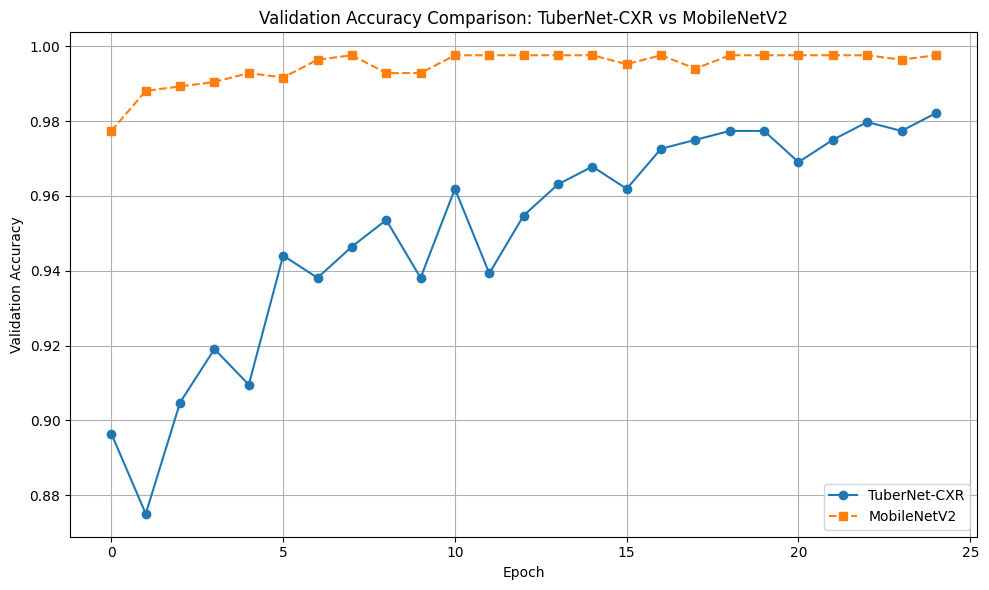

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(history_cnn.history['val_accuracy'], label='TuberNet-CXR', linestyle='-', marker='o')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2', linestyle='--', marker='s')

plt.title('Validation Accuracy Comparison: TuberNet-CXR vs MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


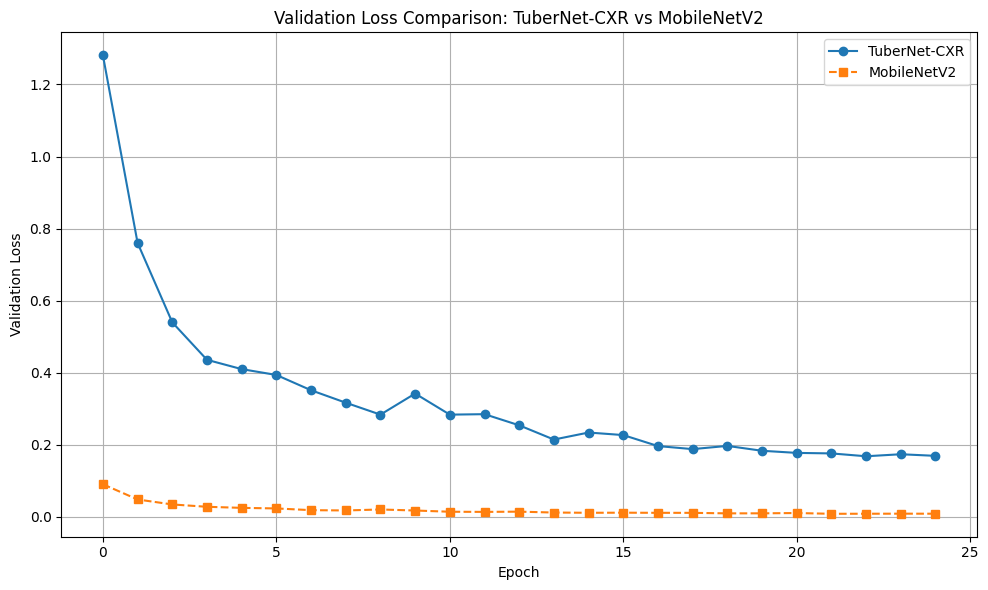

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(history_cnn.history['val_loss'], label='TuberNet-CXR', linestyle='-', marker='o')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2', linestyle='--', marker='s')

plt.title('Validation Loss Comparison: TuberNet-CXR vs MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_cnn = model
# Evaluate TuberNet-CXR
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(val_generator, verbose=1)

# Evaluate MobileNetV2
val_loss_mobilenet, val_acc_mobilenet = model_mobilenet.evaluate(val_generator, verbose=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.9871 - loss: 0.1728
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.9997 - loss: 0.0037


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import numpy as np

# Ground truth
y_true = np.array(val_labels)

# Predictions for CNN
y_pred_cnn = (model_cnn.predict(val_generator) > 0.5).astype(int).flatten()
y_score_cnn = model_cnn.predict(val_generator).flatten()

# Predictions for MobileNetV2
y_pred_mobilenet = (model_mobilenet.predict(val_generator) > 0.5).astype(int).flatten()
y_score_mobilenet = model_mobilenet.predict(val_generator).flatten()


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_533']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_533']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step


In [ ]:
# TuberNet-CXR
metrics_cnn = {
    'Accuracy': accuracy_score(y_true, y_pred_cnn),
    'F1 Score': f1_score(y_true, y_pred_cnn),
    'Precision': precision_score(y_true, y_pred_cnn),
    'Recall': recall_score(y_true, y_pred_cnn),
    'MAE': mean_absolute_error(y_true, y_score_cnn),
    'RMSE': mean_squared_error(y_true, y_score_cnn) ** 0.5  # manually take square root
}


# MobileNetV2
metrics_mobilenet = {
    'Accuracy': accuracy_score(y_true, y_pred_mobilenet),
    'F1 Score': f1_score(y_true, y_pred_mobilenet),
    'Precision': precision_score(y_true, y_pred_mobilenet),
    'Recall': recall_score(y_true, y_pred_mobilenet),
    'MAE': mean_absolute_error(y_true, y_score_mobilenet),
    'RMSE': mean_squared_error(y_true, y_score_mobilenet) ** 0.5
}


In [ ]:
import pandas as pd

# Combine into DataFrame
comparison_df = pd.DataFrame({
    'Model': ['TuberNet-CXR', 'MobileNetV2'],
    'Accuracy': [metrics_cnn['Accuracy'], metrics_mobilenet['Accuracy']],
    'F1 Score': [metrics_cnn['F1 Score'], metrics_mobilenet['F1 Score']],
    'Precision': [metrics_cnn['Precision'], metrics_mobilenet['Precision']],
    'Recall': [metrics_cnn['Recall'], metrics_mobilenet['Recall']],
    'MAE': [metrics_cnn['MAE'], metrics_mobilenet['MAE']],
    'RMSE': [metrics_cnn['RMSE'], metrics_mobilenet['RMSE']],
})

# Round for table formatting
comparison_df = comparison_df.round(4)

# Make your model bold
from IPython.display import display, HTML

styled_df = comparison_df.style.apply(
    lambda x: ['font-weight: bold' if v == 'TuberNet-CXR' else '' for v in x], axis=1
)
display(HTML(styled_df.to_html()))


,Model,Accuracy,F1 Score,Precision,Recall,MAE,RMSE
0,TuberNet-CXR,0.982100,0.938300,0.950000,0.926800,0.067600,0.146600
1,MobileNetV2,0.997600,0.991800,1.000000,0.983700,0.005200,0.047400
